# Homework 2: Regression and Feature Engineering

By Natalia Frumkin and Karanraj Chauhan with the help of B. Kulis, R. Manzelli, and A. Tsiligkaridis

Using climate change datasets from NASA's Climate Change Initiative: https://climate.nasa.gov/vital-signs/

## Preamble

Download the `hw2` folder from here: https://github.com/nfrumkin/EC414/tree/master/homework/hw2 (or clone the EC414 repo, if you prefer).

To run and solve this assignment, you must have a working Jupyter Notebook installation.

If you followed the installation instructions for `Python 3.6.x` and `Jupyter Notebook` from discussion 1, you should be set. In the terminal (cmd for Windows users), navigate to the `hw2` folder. Then type `jupyter notebook` and press `Enter`.

If you have Anaconda, run Anaconda and choose this file ([`Homework 2 - Regression and Feature Engineering.ipynb`](https://gist.githubusercontent.com/MInner/eb6330a655a5c37b82e15d1c84fd4cd0/raw/)) in Anaconda's file explorer. Use `Python 3` version.

Below statements assume that you have already followed these instructions. If you need help with Python syntax, NumPy, or Matplotlib, you might find [Week 1 discussion material](https://github.com/nfrumkin/EC414/blob/master/discussions/Week%201%20-%20Python%20Review.ipynb) useful. 

To run code in a cell or to render [Markdown](https://en.wikipedia.org/wiki/Markdown)+[LaTeX](https://en.wikipedia.org/wiki/LaTeX) press `Ctrl+Enter` or `[>|]`(like "play") button above. To edit any code or text cell [double]click on its content. To change cell type, choose "Markdown" or "Code" in the drop-down menu above.

Put your solution into boxes marked with **`[double click here to add a solution]`** and press Ctrl+Enter to render text. [Double]click on a cell to edit or to see its source code. You can add cells via **`+`** sign at the top left corner.

Submission instructions: please upload your completed solution file to Blackboard by the due date (see Schedule). If you have pen-and-paper answers, please hand them in in class on the same day.

## Problem 1: Linear Algebra Review

Let $B$ be a 4x4 matrix to which we apply the following operations:
1. double column 2
2. interchange columns 1 and 4
3. halve row 1
4. add row 3 to row 1
5. subtract row 4 from each of the other rows
6. replace column 3 by column 4
7. delete column 2 (so that the column dimension is reduced by 1)

(a) Write the result as a product of eight matrices.

(b) Write it again as a product $ABC$ (same $B$) of three matrices.

![p1](p1.png)

## Problem 2: Weighted Least Squares

Given an $n$  x  $d$ matrix $X$ of $n$ data points, each point
$d$-dimensional, an $n$ x $1$ vector $Y$ of observed values and an $n$ x $n$ diagonal weight matrix $A$,
deduce the closed form expression for the coefficients in the weighted linear least squares
regression problem given below. Consider both slope and bias terms as coefficients. In
weighted linear least squares, the term minimized is the weighted sum of squared distances

$\sum_{i=1}^{n}\alpha_i(y_i - \sum_{j=1}^{d}X_{ij}w_j-b)^2$

where $\alpha_i$ is the ith diagonal element of matrix A, and the other symbols have their usual
meaning.

Show all steps in your derivation.

![p2](p2.png)

## Problem 3: Ordinary Least Squares Regression

Given the Greenland ice sheet mass data over the past 17 years (source: `greenland_mass.csv`):

**a.** Plot the data using matplotlib. Be sure to label axes.

**b.** Apply Ordinary Least Squares regression to the data, and predict the ice sheet mass for the time step t=2018 (that is, 1 January 2018).

**c.** Now plot the data and the regression curve in the same figure.

In [4]:
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt

from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet

In [5]:
# read in data
greenland_df = pd.read_csv('greenland_mass.csv', index_col=0)
greenland_df.head()

,time,mass_diff,one_sigma
0,2002.29,0.00,110.39
1,2002.35,12.45,66.04
2,2002.62,-242.15,52.74
3,2002.71,-267.75,63.34
4,2002.79,-279.02,39.55


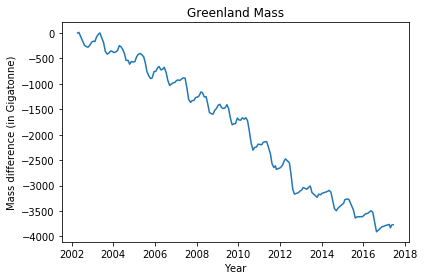

In [10]:
# part a - visualize given data
plt.plot(greenland_df['time'].values, greenland_df['mass_diff'].values)
plt.title('Greenland Mass')
plt.xlabel('Year')
plt.ylabel('Mass difference (in Gigatonne)')
plt.tight_layout()
plt.show()

In [15]:
# part b
# NOTE: scikit learn cannot be used for this part. it is currently being used only for sanity check.
# solution must be coded from scratch
# fit curve using ols regression
ols_model = LinearRegression()
ols_model.fit(X=greenland_df['time'].values.reshape(-1, 1), y=greenland_df['mass_diff'])
print('OLS coefficient = {:.2f} intercept = {:.2f}'.format(ols_model.coef_[0], ols_model.intercept_))

# predict using ols model
pred_mass_var = ols_model.predict(X=[[2018]])
print('2018 predicted mass variation = {:.5f} gigatonnes'.format(pred_mass_var[0]))

OLS coefficient = -277.22 intercept = 555290.51
2018 predicted mass variation = -4130.55564 gigatonnes


In [15]:
def ols_fit(X, y):
    """Calculates least squares regression solution for given data X and labels y

    Uses the formula W = (X^T . X)^-1 . X^T . y, where

    W is the vector of coefficients + intercept
    X is the data matrix with a column of 1's attached
    y is the labels matrix

    Arguments:
        X {np.ndarray} -- (num_points, num_features) shaped ndarray of data points
        y {np.ndarray} -- (num_points, 1) shaped ndarray of labels

    Returns:
        w {np.ndarray} -- (num_features, 1) shaped ndarray representing coefficients
        b {np.ndarray} -- (1, 1) shaped ndarray representing the intercept
    """
    # add column of 1's to X, thus making it X_ext which is needed in the formula
    X_ext = np.concatenate((X, np.ones((X.shape[0], 1))), axis=1)

    # apply the OLS formula to get w_ext
    w_ext = np.linalg.inv(X_ext.transpose() @ X_ext) @ X_ext.transpose() @ y

    # separate coefficients and intercept from w_ext, i.e. get w and b
    w = w_ext[:-1, :]    # all but last value will be coefficients
    b = w_ext[-1:, :]     # last value will be intercept

    return w, b

In [22]:
# extract X and y from dataset
X = greenland_df['time'].values
y = greenland_df['mass_diff'].values

# reshape so that X and y are treated as matrices/vectors, not just array of values
X = X.reshape(-1, 1)    # changes shape from (n,) to (n,1)
y = y.reshape(-1, 1)    # changes shape from (n,) to (n,1)

# calculate the ols solution
w, b = ols_fit(X, y)
print('OLS coefficient = {:.2f} intercept = {:.2f}'.format(w[0, 0], b[0, 0]))

# predict using ols solution
to_pred = [[2018]]
pred_mass_var = to_pred @ w + b
print('2018 predicted mass variation = {:.5f} gigatonnes'.format(pred_mass_var[0, 0]))

OLS coefficient = -277.22 intercept = 555290.51
2018 predicted mass variation = -4130.55564 gigatonnes


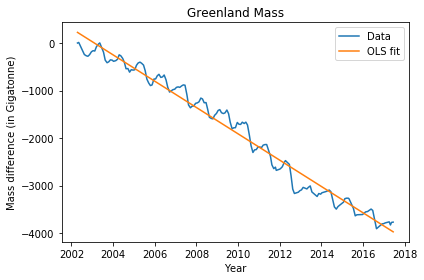

In [24]:
# part c - plotting the model with data
plt.plot(X, y, label='Data')
plt.plot(X, X @ w + b, label='OLS fit')
plt.title('Greenland Mass')
plt.xlabel('Year')
plt.ylabel('Mass difference (in Gigatonne)')
plt.legend()
plt.tight_layout()
plt.show()

## Problem 4: Ridge and Lasso Regression

Given the dataset of airline delays (source: `airline_delays_Xtrain.csv`, `airline_delays_ytrain.csv`):

**a.** For values of lambda 10^3, 10^4, ..., 10^13, fit ridge regression models to the data. Plot a graph of value of coefficient (y-axis) vs log lambda (x-axis) for each coefficient, on the same figure.

**b.** For values of lambda 10^-2, 10^-1, ..., 10^6, fit lasso regression models to the data. Plot a graph of value of coefficient (y-axis) vs log lambda (x-axis) for each coefficient, on the same figure.

**c.** Comment on the difference in how the coefficient values change with log lambda for the two methods.

In [25]:
# read in training data
X_train = pd.read_csv('airline_delays_Xtrain.csv')
y_train = pd.read_csv('airline_delays_ytrain.csv')

In [26]:
# part a

# lambda values for which to fit curve
ridge_lambdas = np.logspace(start=4, stop=14, num=22, base=10)

# exponent corresponding to the lambda value, just here for ease in graphing
ridge_exps = np.log10(ridge_lambdas)

# store the coefficients obtained for each lambda value in this ndarray
# for example, ridge_coefs[0, :] is the coefficients obtained for lambda = 10^3
ridge_coefs = np.empty((ridge_lambdas.shape[0], X_train.shape[1]))

# find coefficients for each lambda value
for i, lamb in enumerate(ridge_lambdas):
    ridge_model = Ridge(alpha=lamb)
    ridge_model.fit(X=X_train, y=y_train)
    ridge_coefs[i, :] = ridge_model.coef_

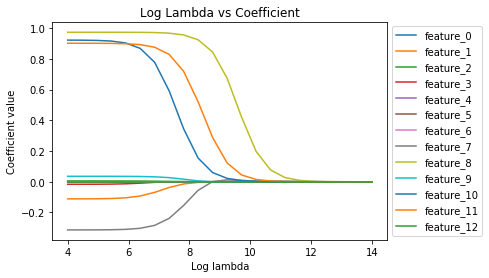

In [27]:
# make the required plot
for feat_num in range(ridge_coefs.shape[1]):
    # this plots the graph of how feat_num th feature changes with lambda
    # we will do this for each feature
    plt.plot(ridge_exps, ridge_coefs[:, feat_num], label='feature_{}'.format(feat_num))

plt.title('Log Lambda vs Coefficient')
plt.xlabel('Log lambda')
plt.ylabel('Coefficient value')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

In [28]:
# part b

# lambda values for which to fit curve
lasso_lambdas = np.logspace(start=-2, stop=6, num=9, base=10)

# exponent corresponding to the lambda value, just here for ease in graphing
lasso_exps = np.log10(lasso_lambdas)

# store the coefficients obtained for each lambda value in this ndarray
# for example, lasso_coefs[0, :] is the coefficients obtained for lambda = 10^-2
lasso_coefs = np.empty((lasso_lambdas.shape[0], X_train.shape[1]))
for i, lamb in enumerate(lasso_lambdas):
    lasso_model = Lasso(alpha=lamb)
    lasso_model.fit(X=X_train, y=y_train)
    lasso_coefs[i, :] = lasso_model.coef_

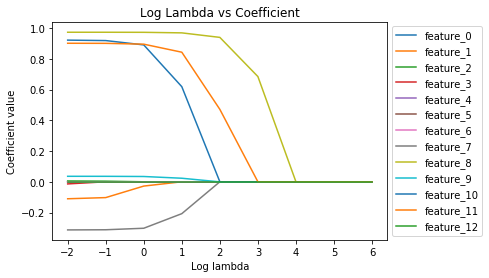

In [29]:
# make the required plot
for feat_num in range(lasso_coefs.shape[1]):
    # this plots the graph of how feat_num-th feature changes with lambda
    # we will do this for each feature
    plt.plot(lasso_exps, lasso_coefs[:, feat_num], label='feature_{}'.format(feat_num))

plt.title('Log Lambda vs Coefficient')
plt.xlabel('Log lambda')
plt.ylabel('Coefficient value')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

**Part c** In lasso, the coefficients fall sharply to 0. In ridge, they smoothly converge to 0.
Lasso is more sensitive to change in lambda than ridge